# Introduction

When modeling complex dynamics that include many factors that cannot be
easily predicted, machine learning is a tool that can help uncover patterns and
efficiently achieve accurate results. Within the context of this project, *I 
used deep neural networks
to predict the paramagnetic to ferromagnetic phase
transition of a material by utilizing the 2D Ising Model*.

### Convolutional Neural Networks

Within the context of this project, the Convolutional Neural Networks (CNNs) takes the **square lattice** Ising configurations across 20 temperatures that are labeled as ordered or disordered depending on the value of the critical temperature. Of these configurations, 80% are used to train the model and the rest of the configurations are unseen samples that validate the model. The trained and validated model is then tested using the configurations of the **triangular lattice**.

The CNN treats Monte Carlo-generated spin configurations as images and learns to classify phases *based on spatial correlations rather than explicit thermodynamic observables*. 

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

### Monte Carlo dataset $\rightarrow$ PyTorch-compatible format

`IsingDataset`: Since PyTorch expects data to be wrapped in `Dataset` object, this class allows each configuration to be treated as an independent sample drawn from the equilibrium distribution

In [ ]:
class IsingDataset(Dataset):
    
    #Constructor: provides full metadata
    def __init__(self, samples):
        self.samples = samples
    
    #Dataset Length: epoch definition for proper batching in training samples   
    def __len__(self):
        return len(self.samples)

## Supervised Learning Parameters

`element`: Entry from structured NumPy array
`label`: Label to identify phase of given configuration 
> $1 \rightarrow$ *ordered*
> $0 \rightarrow$ *disordered*

`configuration`: Corresponds to actual physical state with shape $N \times N$ and values of $\pm 1$
> `configuration_tensor`: **allows each spin configuration to be treated as a grayscale image where pixel values encode spin orientation**

### Metadata

Allows for debugging, sanity, and any post-processing analysis

`phase_indicator`, `temperature`, `sample_index`

In [ ]:
    def __getitem__(self, idx):
        # Extracting information from the structured data
        element, label = self.samples[idx]
        
        # Access specific attributes from the structured array
        phase_indicator = element[0]
        temperature = element[1]
        sample_index = element[2]
        configuration = np.array(element[3])  # Assuming the configuration is the last element
        
        # Process the configuration or extract specific attributes by convert the configuration to a tensor and apply required transformations
        configuration_tensor = torch.from_numpy(configuration).unsqueeze(0).float()
        
        # Return the processed sample and its label
        return configuration_tensor, label






#### Dataset Design

I constructed the dataset in this manner so that only the raw spin configuration is provided to the CNN, ensuring that *classification relied solely on spatial correlations rather than explicit order parameters or temperature information*.

In [ ]:
# Load ordered and disordered configurations
ordered_data = np.load('ordered_configs.npy', allow_pickle=True)
disordered_data = np.load('disordered_configs.npy', allow_pickle=True)

# Create labels for ordered and disordered data
ordered_labels = np.ones(len(ordered_data), dtype=np.int64)
disordered_labels = np.zeros(len(disordered_data), dtype=np.int64)

# Zip the data and labels together for ordered and disordered configurations
ordered_samples = list(zip(ordered_data, ordered_labels))
disordered_samples = list(zip(disordered_data, disordered_labels))

# Split the data into training and validation sets
ordered_train, ordered_val = train_test_split(ordered_samples, test_size=0.2, random_state=42)
disordered_train, disordered_val = train_test_split(disordered_samples, test_size=0.2, random_state=42)

# Form individual samples by extracting attributes and processing the data
processed_ordered_train = [(sample, label) for sample, label in ordered_train]
processed_disordered_train = [(sample, label) for sample, label in disordered_train]
processed_ordered_val = [(sample, label) for sample, label in ordered_val]
processed_disordered_val = [(sample, label) for sample, label in disordered_val]

# Combine the processed samples for training and validation
train_data = IsingDataset(processed_ordered_train + processed_disordered_train)
val_data = IsingDataset(processed_ordered_val + processed_disordered_val)

# CNN Architecture

`self.conv1`: First convolutional layer that probes the nearest-neighbor and short-range correlations
> Chose $3\times3$ kernel to be large enough to capture local physics but small enough to preserve spatial resolution

>`self.pool`: allows network to detect presence or absence of spatial features, ReLU also introduces nonlinearity in classification
>Pooling keeps strongest activations and suppreses micrscopic noise

`self.conv2`: Learns higher-order patterns like domains, composite textures, or correlated structures
>`self.pool`: further reduces spatial scale so that long-range order can influence activations

### Fully-connected Layer
`self.fc1`: combines spatial features into a global representation to learn whether features *collectively* indicate order or disorder

`self.fc2`: Outputs whether configuration is ordered or disordered and is converted to probabilities during training via `CrossEntropyLoss`



In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 10 * 10, 128)  
        self.fc2 = nn.Linear(128, 2)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 10 * 10)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



## Model Assembly

`assemble_nn`: instantiates CNN making the mapping from processing the spin configurations to phase predictions explicit and modular
>Its purpose is to keep the network architecture decoupled from data loading and training logic


In [ ]:
def assemble_nn(input_data):
    model = ConvNet()
    output = model(input_data)
    return output


batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)



for data in train_loader:
    inputs, labels = data
    outputs = assemble_nn(inputs)

# Model Training/Validation

`validate_model`: evaluates trained CNN on separate dataset to measure generalization performance
>Helps ensure network has learned meaningful physical patterns rather than memorizing specific configurations

In this project, accuracy measures whether the CNN has successfully learned the **universal spatial signatures** of phase transitions by counting the number of predictions that are matched to the true labels across the total number of samples


`train_and_validate`: iteratively updates CNN parameters to minimize classification error while monitoring performance on separate validation set to ensure generalization to unseen data

`epoch`: through iteration across all epochs in training batch, this iteratively exposes the network to configurations at different temperatures, which allows it to capture **phase-dependent** spatial patterns. 
>Code prints average loss every 100 batches to help monitor convergence and ensure training is proceeding as expected

In [ ]:
def validate_model(model, criterion, dataloader):
    model.eval()  
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
     
            _, predicted = outputs.max(1)  
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    validate_loss = total_loss / len(dataloader)
    validate_accuracy = 100.0 * correct / total
    return validate_loss, validate_accuracy

def train_and_validate(model, criterion, optimizer, train_loader, validate_loader, epochs):
    for epoch in range(epochs):
        model.train() 
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:  
                print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        # Evaluate the model after each epoch on the validation set
        validate_loss, validate_accuracy = validate_model(model, criterion, validate_loader)
        print(f"[Epoch {epoch + 1}] Validation Loss: {validate_loss:.3f}, Validation Accuracy: {validate_accuracy:.2f}%")

## Model Optimizer and Criterion

`CrossEntropyLoss`: this loss quantifies how well the network predicts the correct phase for a given configuration by computing the relationship between the log loss and predicted probability of selecting the correct class

### Learning Rate

Since the ideal learning rate is a trade-off between convergence speed and the ability ot find the global minima of the loss function, I compared the Adam and Stochastic Gradient Descent (SGD) optimization to see the effects of learning rate on the CNN. 

Below is a summary of my findings:

**Adam:** Increasing learning rate led to faster reduction in validation and test loss. 
> Its adaptive updates efficiently capture local spin correlations, even at higher learning rates

**SGD:** Very low learning rates slowed convergence, while very high rates caused overshooting which resulted in high loss. Intermediate learning rates balanced stability and convergence. 
> Having fixed updates due to uniform step sizes requires careful tuning to capture correlations without instability or undertraining. 

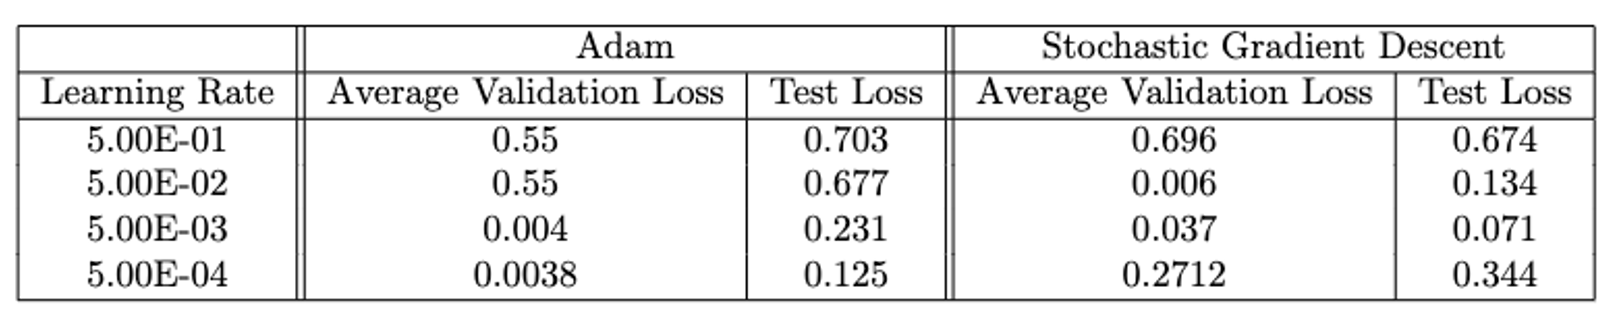


In [ ]:
# Initialize the model, optimizer, and criterion
DNN = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DNN.parameters(), lr=0.0005)
optimizer_SGD = optim.SGD(DNN.parameters(), lr=0.005)


train_and_validate(DNN, criterion, optimizer_SGD, train_loader, validate_loader, epochs=10)

# Model Testing

The following lines implement the goal of the project, which is to test whether the CNN trained on square lattice configurations can generalize to a different lattice geometry. 

`test_loader`: Enforces that each batch contains independent triangular lattice configurations and ensures deterministic evaluations.

`test_model`: Computes the loss and accuracy on phase prediction on the triangular lattice configurations and reports generalization performance

In [ ]:
#Testing on triangular lattice configuration
tri_ordered_data = np.load('tri_ordered_configs.npy', allow_pickle=True)
tri_disordered_data = np.load('tri_disordered_configs.npy', allow_pickle=True)

tri_ordered_labels = np.ones(len(tri_ordered_data), dtype=np.int64)
tri_disordered_labels = np.zeros(len(tri_disordered_data), dtype=np.int64)

tri_ordered_samples = list(zip(tri_ordered_data, tri_ordered_labels))
tri_disordered_samples = list(zip(tri_disordered_data, tri_disordered_labels))

processed_tri_ordered = [(sample, label) for sample, label in tri_ordered_samples]
processed_tri_disordered = [(sample, label) for sample, label in tri_disordered_samples]

test_data = IsingDataset(processed_tri_ordered + processed_tri_disordered)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

def test_model(model, criterion, dataloader):
        model.eval()  
        total_loss = 0
        correct = 0
        total = 0
       
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = outputs.max(1)  
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_loss = total_loss / len(dataloader)
        test_accuracy = 100.0 * correct / total
        #return test_loss, test_accuracy
        print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%")

test_model(DNN,criterion,test_loader)